In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

from sklearn.metrics import (
    precision_recall_curve,
    confusion_matrix,
    roc_curve,
    f1_score,
    roc_auc_score,
)

from typing import Optional
from pathlib import Path
import genetools

In [2]:
from malid import config
from malid.trained_model_wrappers import BlendingMetamodel
import crosseval
from malid.datamodels import (
    GeneLocus,
    SampleWeightStrategy,
    TargetObsColumnEnum,
    CrossValidationSplitStrategy,
    map_cross_validation_split_strategy_to_default_target_obs_column,
)

# Definitions

Sensitivity = True Positive Rate = `P(Positive Test | Lupus)`

Specificity = True Negative Rate = `P(Negative Test | Not Lupus)`

Positive Predictive Value (PPV) is the proportion of those with a positive blood test that have lupus. "If I have a positive test, what is the likelihood I have lupus?"

Negative Predictive Value (NPV) is the proportion of those with a negative blood test that do not have lupus. “If I have a negative test, what is the likelihood I do not have lupus?”

# Load models, as in `analyze_metamodels.ipynb`

In [3]:
base_model_train_fold_name = "train_smaller"
metamodel_fold_label_train = "validation"

gene_locus = config.gene_loci_used
target_obs_column = map_cross_validation_split_strategy_to_default_target_obs_column[
    config.cross_validation_split_strategy
]
metamodel_flavor = "default"

metamodels_base_dir = BlendingMetamodel._get_metamodel_base_dir(
    gene_locus=gene_locus,
    target_obs_column=target_obs_column,
    metamodel_flavor=metamodel_flavor,
)
fname_prefix = (
    f"{base_model_train_fold_name}_applied_to_{metamodel_fold_label_train}_model"
)
model_prefix = metamodels_base_dir / fname_prefix
experiment_set = crosseval.ExperimentSet.load_from_disk(output_prefix=model_prefix)

_output_suffix = Path(gene_locus.name) / target_obs_column.name / metamodel_flavor
output_base_dir = (
    config.paths.second_stage_blending_metamodel_output_dir / _output_suffix
)
results_output_prefix = output_base_dir / fname_prefix

# Calculation

First, plot ROC, which is sensitivity (TPR) vs 1-specificity (FPR). Except we'll flip it to specificity rather than 1-specificity.

Balanced
93% sensitivity, 90% specificity

Harmonic mean
93% sensitivity, 90% specificity

Maximizing Youden's J statistic
93% sensitivity, 90% specificity

High Sensitivity
100% sensitivity, 76% specificity

High Specificity
75% sensitivity, 98% specificity

High Sensitivity 2
84% sensitivity, 95% specificity

High Specificity 2
97% sensitivity, 86% specificity

Max Sensitivity
100% sensitivity, 76% specificity

Max Specificity
0% sensitivity, 100% specificity



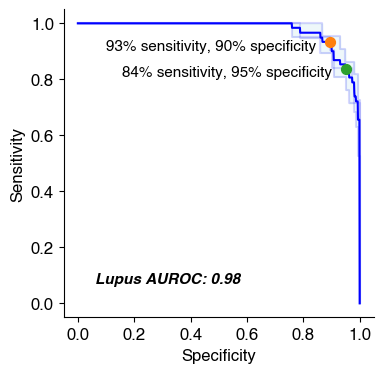

In [4]:
# We will combine ROC curves from different folds. But their x arrays may not be identical, even with drop_intermediate=False. So we will interpolate.
# Use piecewise constant interpolation due to stepwise nature of the ROC curve
# See also https://stats.stackexchange.com/a/187003/297 and https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html


fig, ax = plt.subplots(figsize=(4, 4))

# First define a common set of specificity values along the x axis
base_fpr = np.linspace(0, 1, 1001)
from scipy.interpolate import interp1d

tpr_list = []
auc_scores = []
for fold_id in config.cross_validation_fold_ids:
    perf = experiment_set.model_outputs["ridge_cv", fold_id]
    # Get predicted probabilities for Lupus (vs rest)
    lupus_probs = pd.DataFrame(perf.y_preds_proba, columns=perf.class_names)["Lupus"]

    # Actual binary labels for Lupus vs Rest
    y_true = np.array([1 if label == "Lupus" else 0 for label in perf.y_true])

    auc_scores.append(roc_auc_score(y_true, lupus_probs))

    fpr, tpr, auc_thresholds = roc_curve(y_true, lupus_probs, drop_intermediate=False)

    # Plot raw
    plt.plot(1 - fpr, tpr, "b", alpha=0.15, label=f"ROC fold {fold_id}")

    tpr_interpolator = interp1d(
        fpr,
        tpr,
        # Stepwise constant interpolation:
        kind="previous",
        # Ensure that the function handles points outside the original FPR range by extrapolating to 0 at the beginning and 1 at the end, reflecting the behavior of a ROC curve:
        bounds_error=False,
        fill_value=(0.0, 1.0),
    )
    # Interpolate the TPR at these common FPR values
    tpr_interpolated = tpr_interpolator(base_fpr)
    # Interpolation struggles with boundaries. Let's explicitly set the start and end points so the curves match.
    # - When FPR is 0, TPR should also be 0 (no positive cases are predicted, so true positives should also be 0).
    # - When FPR is 1 (or the maximum FPR in our data), TPR should ideally be the maximum TPR from our data (representing the scenario where all cases are predicted as positive).
    tpr_interpolated[0] = 0  # TPR should be 0 when FPR is 0
    tpr_interpolated[-1] = tpr[
        -1
    ]  # Set the last point to the maximum of the original TPR
    tpr_list.append(tpr_interpolated)

tpr_list = np.array(tpr_list)
mean_tpr = np.mean(tpr_list, axis=0)
sensitivity = mean_tpr  # rename
std_tpr = np.std(tpr_list, axis=0)

specificity = 1 - base_fpr
main_curve = plt.plot(specificity, sensitivity, label="Mean ROC curve", color="b")

# # Adding error bands
# plt.fill_between(specificity, np.maximum(mean_tpr - std_tpr, 0), np.minimum(mean_tpr + std_tpr, 1), color='grey', alpha=0.2, label=r"$\pm$ 1 std. dev.")

# Adding error bands based on real data
plt.fill_between(
    specificity,
    np.min(tpr_list, axis=0),
    np.max(tpr_list, axis=0),
    color="lightblue",
    alpha=0.2,
    label="Min-Max range",
)


plt.ylabel("Sensitivity")
plt.xlabel("Specificity")
# plt.legend()
# plt.title(f"Sensitivity vs Specificity, interpolated, all folds")

all_labels = []
palette = sns.color_palette()[1:]


def make_label(
    name: str, spec: float, sens: float, color: Optional[str] = None, plot: bool = True
):
    def _make_label_str(name, spec, sens):
        # label = f"{name}\n{sens:.0%} sensitivity, {spec:.0%} specificity"
        label = f"{sens:.0%} sensitivity, {spec:.0%} specificity"
        print(name)
        print(label)
        print()
        return label

    def _add_label(x, y, label):
        # plt.text(x, y, label)
        return ax.annotate(
            label,
            xy=(x, y),
            xycoords="data",
            # Offset
            # xytext=(5, 0),
            textcoords="offset points",
            fontsize=11,
            zorder=20,
            #
            xytext=(-10, -3),
            ha="right",
            va="center",
        )

    label_str = _make_label_str(name, spec, sens)
    if plot:
        if color is None:
            color = palette.pop(0)
        plt.scatter(spec, sens, color=color, alpha=1, zorder=20, s=50)
        annotation_obj = _add_label(spec, sens, label_str)
        all_labels.append(annotation_obj)
    return spec, sens


# Find thresholds that optimize one metric while considering the other.


# Balanced Optimal Point
# Calculate the product of sensitivity and specificity for each threshold
product_metric = sensitivity * specificity
# Identify the index of the threshold with the highest product of sensitivity and specificity
optimal_idx = np.argmax(product_metric)
make_label(
    name="Balanced",
    spec=specificity[optimal_idx],
    sens=sensitivity[optimal_idx],
    plot=False,
)

harmonic_mean = 2 * sensitivity * specificity / (sensitivity + specificity)
max_harmonic_idx = np.argmax(harmonic_mean)
make_label(
    name="Harmonic mean",
    spec=specificity[max_harmonic_idx],
    sens=sensitivity[max_harmonic_idx],
    plot=False,
)


youden_j_index = sensitivity + specificity - 1
optimal_youden_j_index = np.argmax(youden_j_index)
make_label(
    name="Maximizing Youden's J statistic",
    spec=specificity[optimal_youden_j_index],
    sens=sensitivity[optimal_youden_j_index],
)


# High Sensitivity Point: the one with max sensitivity while specificity is above a certain absolute threshold (ensure specificity is also relatively high, e.g. above 75%)
condition = specificity > 0.75
valid_indices = np.where(condition)[0]  # Find indices where the condition is True
# Find the index within valid_indices of maximum sensitivity value:
idx_within_valid = np.argmax(sensitivity[valid_indices])
# Retrieve the actual index from original array:
high_sens_idx = valid_indices[idx_within_valid]
make_label(
    name="High Sensitivity",
    spec=specificity[high_sens_idx],
    sens=sensitivity[high_sens_idx],
    plot=False,
)


# High Specificity Point: the one with max specificity while sensitivity is above a certain absolute threshold (ensure sensitivity is also relatively high, e.g. above 75%)
condition = sensitivity > 0.75
valid_indices = np.where(condition)[0]  # Find indices where the condition is True
# Find the index within valid_indices of maximum specificity value:
idx_within_valid = np.argmax(specificity[valid_indices])
# Retrieve the actual index from original array:
high_spec_idx = valid_indices[idx_within_valid]
make_label(
    name="High Specificity",
    spec=specificity[high_spec_idx],
    sens=sensitivity[high_spec_idx],
    plot=False,
)

# Alternative High Sensitivity point while specificity is above a certain relative threshold: 95% of the maximum
# Note: relative threshold doesn't really matter because the values range from 0 to 1 anyway.
# Also note: with this strong a threshold, we end up having the other metric be higher.
# 1) find points where specificity is above 95% of max specificity
high_specificity_indices = np.where(specificity >= 0.95 * np.max(specificity))[0]
# 2) among those points, choose the point with highest sensitivity
optimum_sens_idx = high_specificity_indices[
    np.argmax(sensitivity[high_specificity_indices])
]
make_label(
    name="High Sensitivity 2",
    spec=specificity[optimum_sens_idx],
    sens=sensitivity[optimum_sens_idx],
)

# Alternative High Specificity point while sensitivity is above a certain relative threshold: 95% of the maximum
# see above
high_sensitivity_indices = np.where(sensitivity >= 0.95 * np.max(sensitivity))[0]
optimum_spec_idx = high_sensitivity_indices[
    np.argmax(specificity[high_sensitivity_indices])
]
make_label(
    name="High Specificity 2",
    spec=specificity[optimum_spec_idx],
    sens=sensitivity[optimum_spec_idx],
    plot=False,
)

extreme_sensitivity_idx = np.argmax(sensitivity)
make_label(
    name="Max Sensitivity",
    spec=specificity[extreme_sensitivity_idx],
    sens=sensitivity[extreme_sensitivity_idx],
    plot=False,
)

extreme_specificity_idx = np.argmax(specificity)
make_label(
    name="Max Specificity",
    spec=specificity[extreme_specificity_idx],
    sens=sensitivity[extreme_specificity_idx],
    plot=False,
)


# # Look for bends in the curve, where we start to plateau and get diminishing returns in sensitivity or specificity improvement
# # Calculate slopes between consecutive points
# slopes = np.diff(sensitivity) / np.diff(specificity)

# # Identify points where the change in slope is significant
# # This could be done by looking for large changes in the slope values
# # Here we look for points where the slope decreases significantly
# # These thresholds are arbitrary and might need adjustment based on the specific curve
# significant_change = np.where(np.abs(np.diff(slopes)) > 0.1)[0]

# # Highlight potential critical points
# for idx in significant_change:
#     plt.scatter(specificity[idx], sensitivity[idx], color='black')


sns.despine(ax=ax)

# We considered adjustText but decided against it:
# pip install adjustText>=0.8
# from adjustText import adjust_text
# adjust_text(all_labels, x=specificity, y=sensitivity, ax=ax, time_lim=1)

mean_auroc = np.mean(np.array(auc_scores))
plt.text(
    0.1,
    0.1,
    f"Lupus AUROC: {mean_auroc:0.2f}",
    horizontalalignment="left",
    verticalalignment="bottom",
    transform=ax.transAxes,
    fontsize=11,
    zorder=20,
    weight="bold",
    style="italic",
)

genetools.plots.savefig(
    fig, f"{results_output_prefix}.sensitivity_vs_specificity.lupus.png", dpi=300
)

# Graveyard

Other options for thresholds:

In [5]:
# precision, recall, thresholds = precision_recall_curve(y_true, lupus_probs)

# # Compute F1 score for each threshold
# f1_scores = 2 * (precision * recall) / (precision + recall)

# # Find the threshold that gives the maximum F1 score
# optimal_threshold = thresholds[np.argmax(f1_scores)]

# # Reporting the optimal threshold
# print(
#     f"The optimal threshold is {optimal_threshold:.2f} with a maximum F1 score of {np.max(f1_scores):.2f}."
# )

# # Binarize predictions using the decision_threshold
# binary_predictions = [
#     1 if prob >= optimal_threshold else 0 for prob in lupus_probs
# ]

# # Compute confusion matrix
# tn, fp, fn, tp = confusion_matrix(y_true, binary_predictions).ravel()

# # Compute sensitivity (recall) and specificity
# sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
# specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

# # print(f"Sensitivity = True Positive Rate: P(Positive Test | Lupus) = {sensitivity:0.2f}")
# # print(f"Specificity = True Negative Rate: P(Negative Test | Not Lupus) = {specificity:0.2f}")

# # Calculating the probability of a positive test, by law of total probability
# p_positive_test = (sensitivity * base_rate) + (
#     (1 - specificity) * (1 - base_rate)
# )

# # Calculating the probability of a negative test
# p_negative_test = ((1 - sensitivity) * base_rate) + (
#     specificity * (1 - base_rate)
# )

# # Applying Bayes Rule for PPV
# ppv = (sensitivity * base_rate) / p_positive_test

# # Applying Bayes Rule for NPV
# npv = (specificity * (1 - base_rate)) / p_negative_test

# # print(f"Positive Predictive Value: {ppv:.2f}")
# # print(f"Negative Predictive Value: {npv:.2f}")

# print(
#     {
#         "Decision Threshold": decision_threshold,
#         "Sensitivity": sensitivity,
#         "Specificity": specificity,
#         "Positive Predictive Value": ppv,
#         "Negative Predictive Value": npv,
#     }
# )


# # Alternative:
# # Choose a threshold that gives you the desired balance of precision and recall
# # print(f"Alternate threshold: {thresholds[np.argmin(np.abs(precision - recall))]:0.3f}")

In [6]:
# # Or, choose threshold by first finding highest NPV, then finding highest PPV at that NPV
# def return_row_special(results):
#     return results.loc[
#         results[
#             results["Negative Predictive Value"]
#             == results["Negative Predictive Value"].max()
#         ]["Positive Predictive Value"].idxmax()
#     ]

In [7]:
# # Or, choose threshold by first finding highest specificity, then finding highest sensitivity at that specificity
# def return_row_special_3(results):
#     return results.loc[
#         results[results["Specificity"] == results["Specificity"].max()][
#             "Sensitivity"
#         ].idxmax()
#     ]